In [1]:
import sys
from abc import ABC, abstractmethod
import warnings

import numpy as np
from scipy import optimize
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import multivariate_normal
import scanpy as scp
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import random
import operator
import statsmodels.api as sm


import pandas as pd
import harmonypy as hm
from time import time
import seaborn as sns
import string

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from econml.sklearn_extensions.linear_model import DebiasedLasso as dbl

from scipy.io import mmread
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd
import umap.umap_ as umap
from itertools import permutations

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects.packages import importr
base = importr('base')
utils = importr('utils')
Matrix = importr('Matrix')
#seurat = importr('Seurat')
stats = importr('stats')

warnings.filterwarnings('ignore', category=DeprecationWarning) 

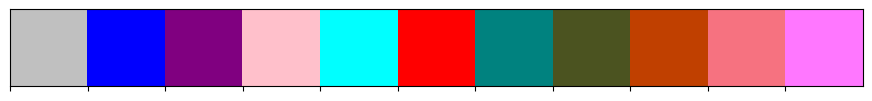

In [2]:
my_favourote_palette = ['#C0C0C0','#0000FF','#800080','#FFC0CB','#00FFFF','#FF0000','#00827F','#4B5320','#C04000','#F67280','#FF77FF']
sns.palplot(sns.color_palette(my_favourote_palette))
customPalette = sns.set_palette(sns.color_palette(my_favourote_palette))

In [3]:
def nearPSD(A,epsilon=0):
   n = A.shape[0]
   eigval, eigvec = np.linalg.eig(A)
   val = np.matrix(np.maximum(eigval,1e-4))
   vec = np.matrix(eigvec)
   T = 1/(np.multiply(vec,vec) * val.T)
   T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
   B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
   out = B*B.T
   return(out)

In [4]:
def invreg(original_matrix, epsilon=1e-3):
    """
    Invert a matrix with regularization to avoid singularity.

    Parameters:
    - original_matrix: Input matrix to be inverted.
    - epsilon: Small value for regularization.

    Returns:
    - inverted_matrix: Inverted matrix.
    """

    # Adding a small diagonal matrix to avoid singularity
    diagonal_matrix = epsilon * np.eye(original_matrix.shape[0])
    regularized_matrix = original_matrix + diagonal_matrix

    # Invert the regularized matrix
    inverted_matrix = np.linalg.inv(regularized_matrix)

    return inverted_matrix

In [5]:
def replace_zeros_with_small_number(array, small_number=1e-30):
    """
    Replace zero values in a NumPy array with a very small number.

    Parameters:
    - array: NumPy array.
    - small_number: The small number to replace zero values with. Default is 1e-10.

    Returns:
    - Modified NumPy array with zero values replaced.
    """
    array[array == 0] = small_number
    return array

# Utils Function

In [6]:
def machineEpsilon(func=float):
    machine_epsilon = func(1)
    while func(1)+func(machine_epsilon) != func(1):
        machine_epsilon_last = machine_epsilon
        machine_epsilon = func(machine_epsilon) / func(2)
    return machine_epsilon_last

In [7]:
# Creates a UMAP visualization of high dimensional data
## Input: Feature set, labels, colors of clusters
## Output: UMAP plot

def umap_visualize(arr, labels, palette="hls"):
    u = umap.UMAP().fit_transform(
        arr
    )
    umap_data = pd.DataFrame({'u0': u[:, 0], 'u1': u[:, 1], 'label': labels})
    sns.scatterplot(data=umap_data, x='u0', y='u1', hue='label', palette=palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [8]:
# Obtains misclassicfication error with respect to a given clustering
## Input: number of clusters, true clusters, estimated clusters
## Output: misclassification error

def misclassification_rate(k, sigma, sigmahat):
    # given two clustering of length p sigma(i) in {0, 1, ..., k-1}
    # return their misclassification rate up to permutation
    # k is the number of clusters
    p = len(sigma)
    res = 1
    new_sigma = [0] * p
    for perm in permutations(range(k)):
        for i in range(p):
            new_sigma[i] = perm[sigmahat[i]]
        cur = sum(a != b for a, b in zip(sigma, new_sigma))
        res = min(res, cur/p)
    return res

In [9]:
# Fits K-Means and obtains labels for a set of features
## Input: Feature Matrix, number of clusters
## Output: k means labels

def get_kmeans_label(feature, k = 2):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature)
    kmeans = KMeans(
        init = "random",
        n_clusters = k,
        n_init = 10,
        max_iter = 300,
        random_state = 42
        )
    kmeans.fit(scaled_features)
    return kmeans.labels_

In [10]:
# Computes robust SVD
## Input: Features, number of singular values
## Output: Singular vectors and Values

def robust_svd(arr, n_components, randomized=False, n_runs=1):
    """
    Do deterministic or randomized SVD on arr.
    Parameters
    ----------
    arr: np.array
        The array to do SVD on
    n_components: int
        Number of SVD components
    randomized: bool, default=False
        Whether to run randomized SVD
    n_runs: int, default=1
        Run multiple times and take the realization with the lowest Frobenious reconstruction error

    Returns
    -------
    u, s, vh: np.array
        u @ np.diag(s) @ vh is the reconstruction of the original arr
    """
    if randomized:
        best_err = float('inf')
        u, s, vh = None, None, None
        for _ in range(n_runs):
            curr_u, curr_s, curr_vh = randomized_svd(arr, n_components=n_components, random_state=None)
            curr_err = np.sum((arr - curr_u @ np.diag(curr_s) @ curr_vh) ** 2)
            if curr_err < best_err:
                best_err = curr_err
                u, s, vh = curr_u, curr_s, curr_vh
        assert u is not None and s is not None and vh is not None
    else:
        if n_runs > 1:
            warnings.warn("Doing deterministic SVD, n_runs reset to one.")
        u, s, vh = svds(arr*1.0, k=n_components) # svds can not handle integer values
    return u, s, vh

In [11]:
# Divides a row by its sum and sclaes it to a reference value
## Input: Frow to be sclaed, reference value
## Output: scaled row

def normalize_vector(v, scale_factor):
    return (v / np.sum(v)) * scale_factor

In [12]:
# Normalizes given cell by features matrix to remove sequencing depth irregularities
## Input: Matrix to be normalized and scaled
## Output: Normalized matrix

def normalize_data_matrix(A, scale_factor):
    A_temp = np.apply_along_axis(np.log1p, 1, A)
    A_temp = np.apply_along_axis(normalize_vector, 1, A_temp, scale_factor)  
    return A_temp

In [13]:
### Corrects Singular Values

def _convert_singular_val(y, gamma):
    under_sqrt = (gamma * y ** 2 - (1 + gamma)) ** 2 - 4 * gamma
    t = np.zeros(len(under_sqrt))
    where_positive = np.where(y >= 0)[0]
    where_negative = np.where(y < 0)[0]
    t[where_positive] = (gamma * y[where_positive] ** 2 - (1 + gamma) + np.sqrt(under_sqrt[where_positive]))/ (2 * gamma)
    t[where_negative] = y[where_negative] 
    return np.sqrt(t)

In [14]:
# Generate support of the prior by k-means
## Input: feature matrix, number of clusters, mean
## Output: set of support points

def extract_support(feature, k, mu, do_k_means):
    if do_k_means == 0:
        support = feature.dot(np.linalg.pinv(mu).T)
        return support 
    else:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(feature)
        kmeans = KMeans(
         init = "random",
         n_clusters = k,
         n_init = 10,
         max_iter = 300,
         random_state = 42
         )
        kmeans.fit(scaled_features)
        cen = kmeans.cluster_centers_
        support = cen.dot(np.linalg.pinv(mu).T)
        return support

In [15]:
def sqrtmplaw(x, n_samples = 0, n_features = 0):
    '''we require the noise variance to be 1/n_samples
    '''
    aspect_ratio = n_features/n_samples
    lambda_plus = (1+np.sqrt(aspect_ratio))**2
    lambda_minus = (1 - np.sqrt(aspect_ratio))**2
    if x < lambda_minus or x > lambda_plus:
        return 0
    else: 
        return 1/(np.pi * aspect_ratio * x) * np.sqrt((lambda_plus - x)*(x - lambda_minus))

def sqrtMPlaw(arr, n, p):
    return [sqrtmplaw(x, n, p) for x in arr]

# Data Preprocessing

In [16]:
## Read the protein data

data_protein = utils.read_csv('cleaned_adt_tea_seq.csv')
data_protein = pd.DataFrame(data_protein)
A = data_protein.to_numpy()
A = A.T
A = np.delete(A, obj = 0, axis = 1)
A = A.astype('float64')

## Determining the factor to scale the data 
scale_factor_A = round(np.median(A.sum(axis = 1)), -3)

## Normalize the reduced data matrix

A = normalize_data_matrix(A, scale_factor_A)

# Select 20 highly variable proteins
var_up_A = np.var(A, axis = 0)
ind_up_A = np.argpartition(var_up_A, -40)[-40:]
A = A[:,ind_up_A]

## Centering A

mean_A = np.mean(A, axis=0)
A = A - mean_A


<Axes: >

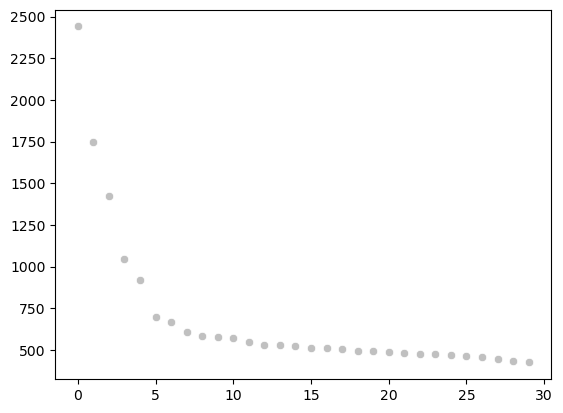

In [17]:
## Studying the dominant atac PC's

U1_init_ad, S1_init_ad, V1_init_ad = np.linalg.svd(A, full_matrices = False)
plot_svd_ad = S1_init_ad[:30]
sns.scatterplot(data = plot_svd_ad) 

In [18]:
## Preprocessing for testing
k_A = 10
U_A_adj, S_A_adj, V_A_adj = np.linalg.svd(A, full_matrices = False)
A_readjusted = U_A_adj[:,:k_A] @ np.diag(S_A_adj[:k_A]) 
projector_A = V_A_adj[:k_A,:]
A_original = A
A = A_readjusted

In [19]:
## Compute estimate of L

cov_A = (1 / A.shape[0]) * A.T @ A
L_rough = cov_A - np.identity(A.shape[1])
val, vec = np.linalg.eig(L_rough)
diag_adjust = np.diag(np.sqrt(val))
L = vec @ diag_adjust

In [20]:
## Reading in atac Data

data_atac = scp.read_h5ad('cleaned_atac_reads_tea_seq.h5ad')
B_raw = data_atac.X
B_raw = pd.DataFrame(B_raw)
B_raw = B_raw.to_numpy()
B_raw = B_raw.T

## Rescaling the matrix to get 1/sqrt(n) scaling

B = B_raw / np.sqrt(B_raw.shape[0])
B = B.astype('float64')

In [21]:
## Reading in RNA Data

data_rna = scp.read_h5ad('cleaned_rna_reads_tea_seq.h5ad')
C_raw = data_rna.X
C_raw = pd.DataFrame(C_raw)
C_raw = C_raw.to_numpy()
C_raw = C_raw.T

## Rescaling the matrix to get 1/sqrt(n) scaling

C = C_raw / np.sqrt(C_raw.shape[0])
C = C.astype('float64')


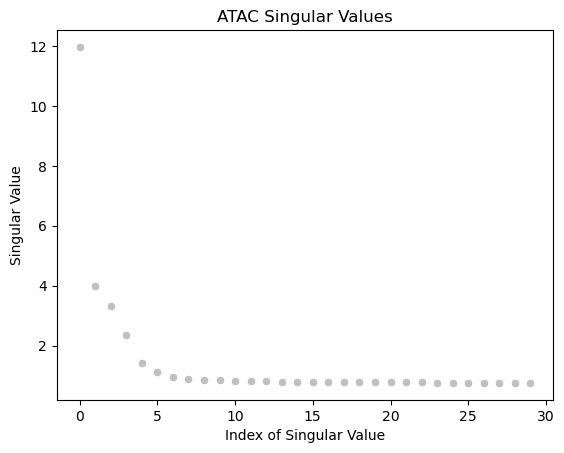

In [22]:
## Studying the dominant atac PC's

U1_init_bn, S1_init_bn, V1_init_bn = np.linalg.svd(B, full_matrices = False)
plot_svd = S1_init_bn[:30]
sns.scatterplot(data = plot_svd) 
plt.xlabel('Index of Singular Value')
plt.ylabel('Singular Value')
plt.title('ATAC Singular Values')
plt.show()


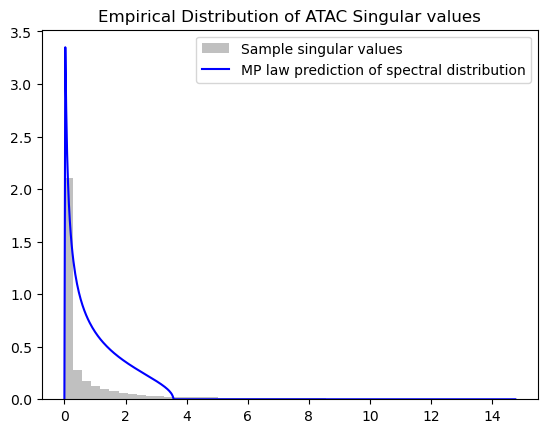

In [23]:
## Correcting for the noise variance

k_B = 10
n_features_B = B.shape[1]
n_samples_B = B.shape[0]
B_residual = B-U1_init_bn[:,:k_B] @ np.diag(S1_init_bn[:k_B]) @ V1_init_bn[:k_B,:]
tau_sq_correct_B = np.sum(B_residual**2) / n_features_B 
B_residual = B_residual/np.sqrt(tau_sq_correct_B)
U1_init_res_B, S1_init_res_B, V1_init_res_B = np.linalg.svd(B_residual, full_matrices = False)
fig, ax = plt.subplots()
sq_singular_val_B = S1_init_res_B ** 2
shorter_side_B = min(n_samples_B, n_features_B)
ax.hist(sq_singular_val_B[:shorter_side_B], density = True, bins = 50, label = "Sample singular values")
x = np.linspace(sq_singular_val_B.min(), sq_singular_val_B.max(), num = 500)
aspect_ratio = n_features_B / n_samples_B
if aspect_ratio > 1:
    scaler = aspect_ratio
else:
    scaler = 1
ax.plot(x, scaler*np.array(sqrtMPlaw(x, n_samples_B, n_features_B)), label = "MP law prediction of spectral distribution")
ax.legend()
ax.set_title("Empirical Distribution of ATAC Singular values") 
plt.show()

<Axes: >

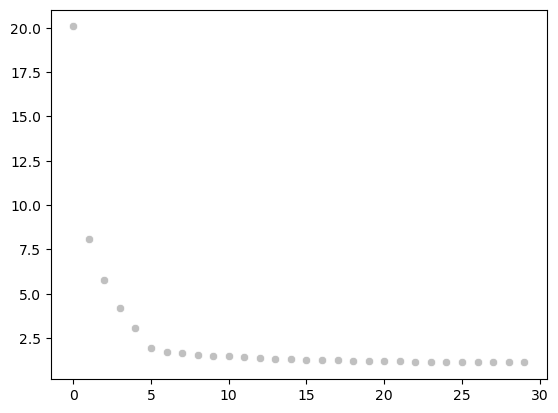

In [24]:
## Studying the dominant rna PC's

U2_init_bn, S2_init_bn, V2_init_bn = np.linalg.svd(C, full_matrices = False)
plot_svd = S2_init_bn[:30]
sns.scatterplot(data = plot_svd) 

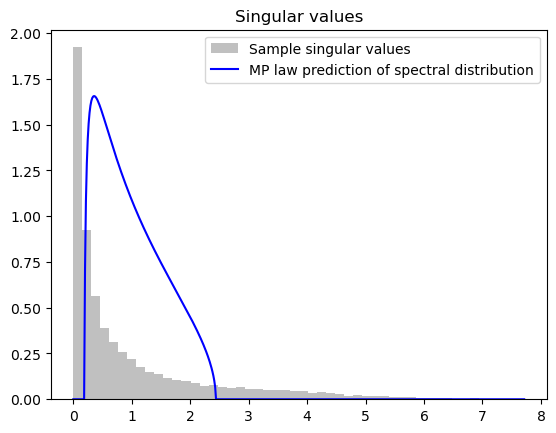

In [25]:
## Correcting for the noise variance

k_C = 15
n_features_C = C.shape[1]
n_samples_C = C.shape[0]
C_residual = C-U2_init_bn[:,:k_C] @ np.diag(S2_init_bn[:k_C]) @ V2_init_bn[:k_C,:]
tau_sq_correct_C = np.sum(C_residual**2) / n_features_C 
C_residual = C_residual/np.sqrt(tau_sq_correct_C)
U2_init_res_C, S2_init_res_C, V2_init_res_C = np.linalg.svd(C_residual, full_matrices = False)
fig, ax = plt.subplots()
sq_singular_val_C = S2_init_res_C ** 2
shorter_side_C = min(n_samples_C, n_features_C)
ax.hist(sq_singular_val_C[:shorter_side_C], density = True, bins = 50, label = "Sample singular values")
x = np.linspace(sq_singular_val_C.min(), sq_singular_val_C.max(), num = 500)
aspect_ratio = n_features_C / n_samples_C
if aspect_ratio > 1:
    scaler = aspect_ratio
else:
    scaler = 1
ax.plot(x, scaler*np.array(sqrtMPlaw(x, n_samples_C, n_features_C)), label = "MP law prediction of spectral distribution")
ax.legend()
ax.set_title("Singular values") 
plt.show()

In [26]:
# Rescale the data matrices

A_reduced = A
B_reduced = B / np.sqrt(tau_sq_correct_B)
C_reduced = C / np.sqrt(tau_sq_correct_C)

In [27]:
# Clean up the meta data

meta = utils.read_csv('cleaned_cell_labels_meta_tea_seq.csv')
meta = pd.DataFrame(meta)
meta = meta.T
meta = meta.to_numpy()
meta = np.delete(meta, obj = 0, axis = 1)
labels = meta.flatten(order='C')

In [28]:
seed = 10

In [29]:
## Aspect Ratios

gamma_1 = B_reduced.shape[1]/B_reduced.shape[0]
gamma_2 = C_reduced.shape[1]/C_reduced.shape[0]

In [37]:
## Compute Singular Value Decomposition of B for WNN

k_wnn = 50

U1_init_wnn, S1_init_wnn, V1_init_wnn = np.linalg.svd(B_reduced, full_matrices = False)
s_hat_wnn = S1_init_wnn[:k_wnn] / np.sqrt(gamma_1)
S_hat_wnn = np.diag(s_hat_wnn)

sigma_x_wnn = (1 + gamma_1 * s_hat_wnn ** 2) / (gamma_1 * s_hat_wnn ** 2 * (s_hat_wnn ** 2 + 1))
mu_x_wnn = np.sqrt(1 - sigma_x_wnn)
sigmabar_x_wnn = (1 + s_hat_wnn ** 2) / (s_hat_wnn ** 2 * (gamma_1 * s_hat_wnn ** 2 + 1))
mubar_x_wnn = np.sqrt(1 - sigmabar_x_wnn)

# initialize M0 and Q0 for X

M_0_x_wnn = np.diag(mu_x_wnn)
Sigma_0_x_wnn = np.diag(sigma_x_wnn)
M_bar_x_wnn = np.diag(mubar_x_wnn)
Sigma_bar_x_wnn = np.diag(sigmabar_x_wnn)

In [38]:
## Compute Singular Value Decomposition of C for WNN

k_2_wnn = 50

U2_init_wnn, S2_init_wnn, V2_init_wnn = np.linalg.svd(C_reduced, full_matrices = False)
s_tilde_wnn = S2_init_wnn[0:k_2_wnn] / np.sqrt(gamma_2)
S_tilde_wnn = np.diag(s_tilde_wnn)

sigma_y_wnn = (1 + gamma_2 * s_tilde_wnn ** 2) / (gamma_2 * s_tilde_wnn ** 2 * (s_tilde_wnn ** 2 + 1))
mu_y_wnn = np.sqrt(1 - sigma_y_wnn)
sigmabar_y_wnn = (1 + s_tilde_wnn ** 2) / (s_tilde_wnn ** 2 * (gamma_2 * s_tilde_wnn ** 2 + 1))
mubar_y_wnn = np.sqrt(1 - sigmabar_y_wnn)

# initialize M0 and Q0 for Y

M_0_y_wnn = np.diag(mu_y_wnn)
Sigma_0_y_wnn = np.diag(sigma_y_wnn)
M_bar_y_wnn = np.diag(mubar_y_wnn)
Sigma_bar_y_wnn = np.diag(sigmabar_y_wnn)

In [39]:
n = B_reduced.shape[0]; p_1 = B_reduced.shape[1]; p_2 = C_reduced.shape[1]

In [40]:
## Scaling of the singular vectors of B and C for wnn

F_x_wnn = np.sqrt(n) * U1_init_wnn[:,:k_wnn]
G_x_wnn = np.sqrt(p_1) * V1_init_wnn.T[:,:k_wnn]

F_y_wnn = np.sqrt(n) * U2_init_wnn[:,:k_2_wnn]
G_y_wnn = np.sqrt(p_2) * V2_init_wnn.T[:,:k_2_wnn]

G_wnn = G_x_wnn
U_x_t_wnn = F_x_wnn @ sp.linalg.sqrtm(Sigma_0_x_wnn)

Gbar_wnn = G_y_wnn
U_y_t_wnn = F_y_wnn @ sp.linalg.sqrtm(Sigma_0_y_wnn)

In [41]:
## Store Raw PC's to run WNN

pc_x_for_seurat_with_pred = pd.DataFrame(F_x_wnn)
pc_x_for_seurat_with_pred.to_csv('pc_atac_wnn.csv')
pc_y_for_seurat_with_pred = pd.DataFrame(F_y_wnn)
pc_y_for_seurat_with_pred.to_csv('pc_rna_wnn.csv')

In [42]:
pc_z_for_seurat_with_pred = pd.DataFrame(U_A_adj[:,:30] @ np.diag(S_A_adj[:30]) )
pc_z_for_seurat_with_pred.to_csv('pc_adt_wnn.csv')